# Decision Tree

In [1]:
import pandas as pd
import numpy as np
import math
import sklearn
import graphviz
from matplotlib import pyplot as plt
from tensorflow import keras
from IPython.display import display
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

#### Data management functions

In [2]:
# Imports data (daily or non-daily)
def import_function(daily):
    if daily == True:
        data = pd.read_excel('master_thesis_data_daily.xlsx', index_col=[0])
        y    = data.NO_folio_rate
        data.drop(['NO_folio_publication_date', 'NO_folio_rate'], axis=1, inplace=True)
    else:
        data = pd.read_excel('master_thesis_data.xlsx', index_col=[0])
        y    = data.NO_folio_publication_date
        data.drop('NO_folio_publication_date', axis=1, inplace=True)
    
    return data, y

def periods(data, y, periods):
    y_name = y.name
    y_temp = y.pct_change(periods).replace(np.nan, 0)
    temp   = pd.concat([y_temp.shift(-periods + 1).dropna(), data], join='inner', axis=1)
    y      = temp[y_name]
    temp.drop(y_name, axis=1, inplace=True)
    
    return temp, y

# Splits data into train and test 
def TT_split(x, y, daily, test_pct):
    if test_pct == 'fixed':
        if daily == True: split = 4507
        else: split = 128
    else:   
        split = int(len(x)*(1-test_pct))

    x_train, x_test = x[:split], x[split:]
    y_train, y_test = y[:split], y[split:]

    return x_train, x_test, y_train, y_test

# Normalizes x-variables based on x_train scales
def mm_normalize(x_train, x_test):
    scaler  = MinMaxScaler(feature_range=(0, 1)).fit(x_train)
    x_train = scaler.transform(x_train)
    x_test  = scaler.transform(x_test)
    
    return x_train, x_test

#### Import data

In [3]:
daily       = False
data, folio = import_function(daily=daily)

# Add 1 lag of folio rate and remove NaN
data['folio_lag'] = folio.pct_change().shift(1).replace(np.nan, 0)[2:]
data.dropna(inplace=True)
folio = folio[1:]
split = int(len(folio[1:]) * 0.8)

#### Hyperparameter tuning and defining model

In [12]:
# Defining a Decision Tree model
def DT_model(x_train, x_test, y_train, y_test):
    
    p = {'max_depth':         [4, 5, 6, 8, 10],
         'min_samples_split': [20, 50, 100, 200, 300, 500],
         'min_samples_leaf':  [20, 50, 75,  100, 150, 300]}
    
    DT_hyper = tree.DecisionTreeRegressor()
    DT_hyper.fit(x_train, y_train)
    
    grid = GridSearchCV(DT_hyper, param_grid=p, cv=10, verbose=1, n_jobs=-1)
    grid.fit(x_train, y_train)
    
    DT_mod = tree.DecisionTreeRegressor(splitter='best', 
                                        max_depth=         grid.best_estimator_.max_depth,
                                        min_samples_split= grid.best_estimator_.min_samples_split,
                                        min_samples_leaf=  grid.best_estimator_.min_samples_leaf,
                                        random_state=8)

    history = DT_mod.fit(x_train, y_train)

    y_pred     = DT_mod.predict(x_test)
    train_pred = DT_mod.predict(x_train)
    test_RMSE  = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
    
    print("Test MSE: %.8f" % test_RMSE)
    
    display(graphviz.Source(tree.export_graphviz(DT_mod, feature_names = data.columns, rotate=False)))
    
    return y_pred, train_pred, history, test_RMSE, DT_mod

#### Run model

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Test MSE: 0.22484810


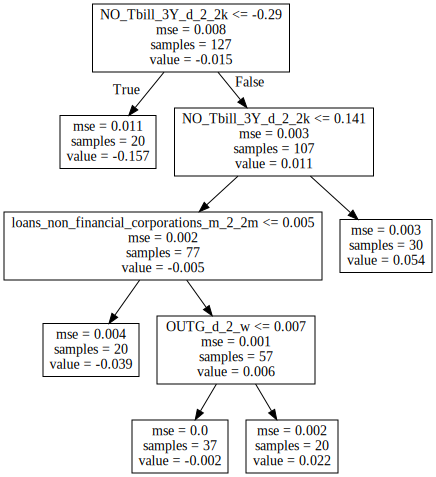

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Test MSE: 0.29748601


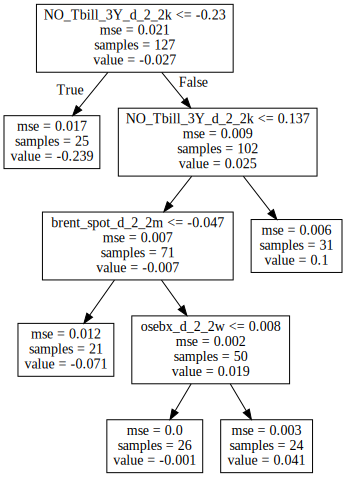

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Test MSE: 0.37169659


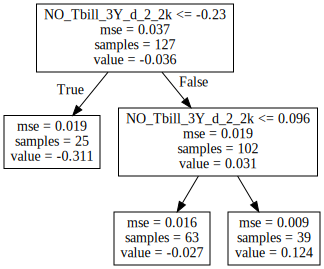

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Test MSE: 0.45848648


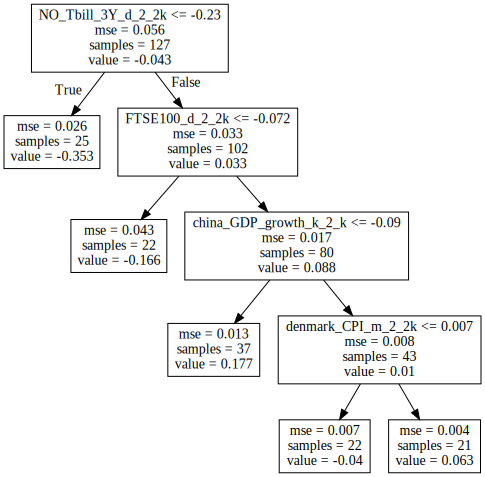

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Test MSE: 0.52935258


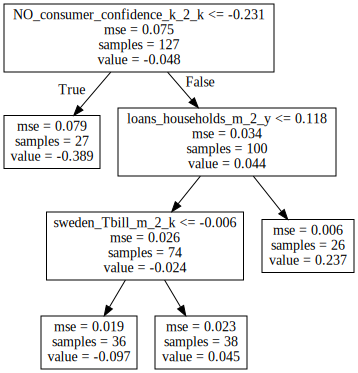

In [13]:
y_pred, train_pred, history, test_RMSE, ys, ys_train = {}, {}, {}, {}, {}, {}

for period in range(1, 6):
    
    x, y = periods(data, folio, periods=period)
    x_train, x_test = x[:split], x[split:]
    y_train, y_test = y[:split], y[split:]
    
    y_hat, train_hat, historie, RMSE, DT_mod = DT_model(x_train, x_test, y_train, y_test)
    
    y_pred    ["y_pred_{0}"    .format(period)] = y_hat
    train_pred["train_pred_{0}".format(period)] = train_hat
    history   ["history_{0}"   .format(period)] = historie
    test_RMSE ["test_RMSE_{0}" .format(period)] = RMSE
    ys        ["ys_test_{0}"   .format(period)] = y_test
    ys_train  ["ys_train_{0}"  .format(period)] = y_train

#### Manage results

In [6]:
for key in ys.keys():
    ys[str(key)] = ys[str(key)].values.tolist()
    
for key in y_pred.keys():
    y_pred[str(key)] = y_pred[str(key)].tolist()
    
comb_y_test = pd.DataFrame.from_dict(ys,     orient='index').transpose()
comb_y_pred = pd.DataFrame.from_dict(y_pred, orient='index').transpose()
comb_y_test.index, comb_y_pred.index = folio.index[split+1:], folio.index[split+1:]
comb_y_pred.columns = ['y_oos_pred_0', 'y_oos_pred_1', 'y_oos_pred_2', 'y_oos_pred_3', 'y_oos_pred_4']
comb_y_test.columns = ['y_test_0', 'y_test_1', 'y_test_2', 'y_test_3', 'y_test_4']

for i in range(5):
    comb_y_test.iloc[:, i] = folio[split-1:].shift(1).dropna() * (comb_y_test.iloc[:, i] + 1)
    comb_y_pred.iloc[:, i] = folio[split-1:].shift(1).dropna() * (comb_y_pred.iloc[:, i] + 1)

NB = pd.read_excel('Styringsrenter_sammensatt.xlsx', index_col=[1])
NB.drop('Quarter', axis=1, inplace=True)
NB.drop(NB.iloc[:, 5:], axis=1, inplace=True)
NB.dropna(inplace=True)
NB = NB / 100

comparison = pd.concat([comb_y_test, comb_y_pred, NB], axis=1, join='inner')

#### Plot results

Text(0.5, 1.0, 'Decision Tree')

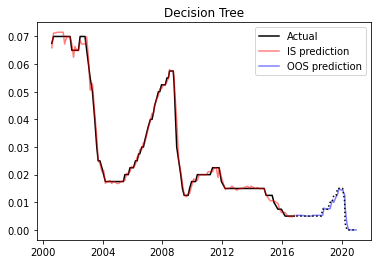

In [7]:
plt.plot(folio.index[1:split+1], (ys_train['ys_train_1'][:split] + 1) * folio[:split+1].shift(1).dropna(), color = "black", label = "Actual")
plt.plot(folio.index[1:split+1], (train_pred['train_pred_1'][:split] + 1) * folio[:split+1].shift(1).dropna(), color = "Red",   alpha = 0.5, label = "IS prediction")
plt.plot(folio.index[split+1:], comb_y_pred['y_oos_pred_0'], color = "Blue",   alpha = 0.5, label = "OOS prediction")
plt.plot(folio.index[split+1:], comb_y_test['y_test_0'], color = "black", linestyle=':')
plt.legend()
plt.title("Decision Tree")

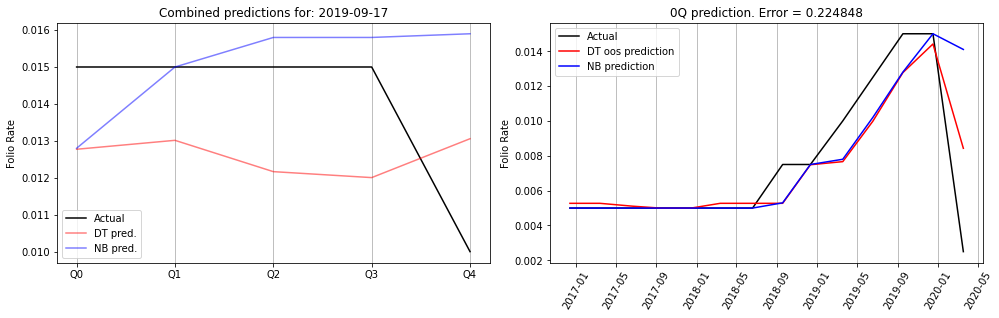

In [8]:
time  = ['Q0', 'Q1', 'Q2', 'Q3', 'Q4']
serie = 11

fig = plt.figure(figsize = (14, 8))

plt.subplot2grid((2, 2), (0, 0), colspan = 1, rowspan = 1)
plt.plot(time, comparison.iloc[serie, :5].values,   color = "black", label = "Actual")
plt.plot(time, comparison.iloc[serie, 5:10].values, color = "red",   alpha = 0.5, label = "DT pred.")
plt.plot(time, comparison.iloc[serie, 10:].values,  color = "blue",  alpha = 0.5, label = "NB pred.")
plt.title("Combined predictions for: " + str(comparison.index[serie].date()))
plt.ylabel("Folio Rate")
plt.legend()
plt.grid(axis = 'x')

plt.subplot2grid((2, 2), (0, 1), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 0],  color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 5],  color= "red",   label = "DT oos prediction")
plt.plot(comparison.iloc[:, 10], color= "blue",  label = "NB prediction")
plt.title("0Q prediction. Error = " + str(round(test_RMSE['test_RMSE_1'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.legend()
plt.grid(axis = 'x')

plt.tight_layout()

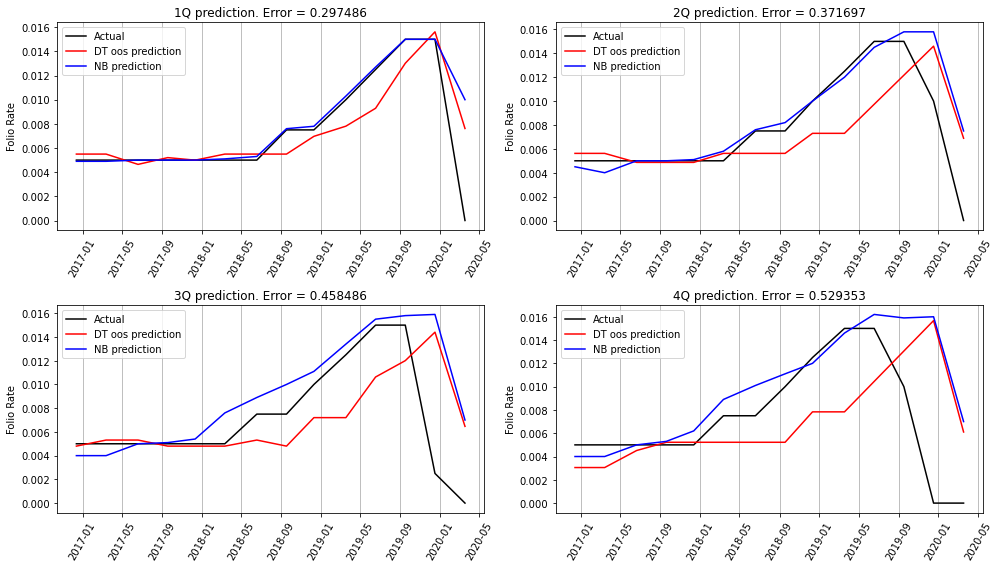

In [9]:
fig = plt.figure(figsize = (14, 8))

plt.subplot2grid((2, 2), (0, 0), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 1],  color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 6],  color= "red",   label = "DT oos prediction")
plt.plot(comparison.iloc[:, 11], color= "blue",  label = "NB prediction")
plt.title("1Q prediction. Error = " + str(round(test_RMSE['test_RMSE_2'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.grid(axis = 'x')
plt.legend()

plt.subplot2grid((2, 2), (0, 1), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 2],  color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 7],  color= "red",   label = "DT oos prediction")
plt.plot(comparison.iloc[:, 12], color= "blue",  label = "NB prediction")
plt.title("2Q prediction. Error = " + str(round(test_RMSE['test_RMSE_3'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.grid(axis = 'x')
plt.legend()

plt.subplot2grid((2, 2), (1, 0), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 3],  color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 8],  color= "red",   label = "DT oos prediction")
plt.plot(comparison.iloc[:, 13], color= "blue",  label = "NB prediction")
plt.title("3Q prediction. Error = " + str(round(test_RMSE['test_RMSE_4'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.grid(axis = 'x')
plt.legend();

plt.subplot2grid((2, 2), (1, 1), colspan = 1, rowspan = 1)
plt.plot(comparison.iloc[:, 4], color= "black", label = "Actual")
plt.plot(comparison.iloc[:, 9], color= "red", label = "DT oos prediction")
plt.plot(comparison.iloc[:, 14], color= "blue", label = "NB prediction")
plt.title("4Q prediction. Error = " + str(round(test_RMSE['test_RMSE_5'], 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60)
plt.grid(axis = 'x')
plt.legend();

plt.tight_layout()

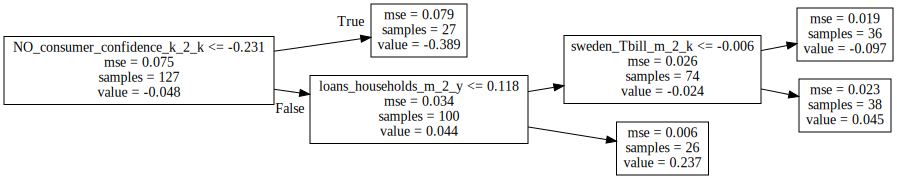

In [10]:
display(graphviz.Source(tree.export_graphviz(DT_mod, feature_names = data.columns, rotate=True)))

In [11]:
# comb_y_pred.to_excel('DT_predictions_stationary.xlsx')